<a href="https://colab.research.google.com/github/HarshitGarg-web/Computer-vision-tasks/blob/main/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [239]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
fdataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
dataloader = torch.utils.data.DataLoader(dataset=fdataset, batch_size=bs, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [240]:
len(dataloader)

600

In [241]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets
 
import torchvision
from torchvision import transforms
from torchvision import models
 
import torch.nn.functional as F
import torchvision.transforms.functional as TF
 
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import time

from tqdm import tqdm 

import skimage
from skimage import img_as_ubyte, img_as_float32

from sklearn.model_selection import StratifiedShuffleSplit

from glob import glob

from torchsummary import summary

import math
import os


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [242]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        z=eps.mul(std).add_(mu)
        
        return  z # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=10)
if torch.cuda.is_available():
    vae.cuda()


In [243]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=10, bias=True)
  (fc32): Linear(in_features=256, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [244]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [245]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))

In [246]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(dataloader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [247]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.311367


/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [10000/60000 (17%)]	Loss: 277.073418
Train Epoch: 1 [20000/60000 (33%)]	Loss: 280.309062
Train Epoch: 1 [30000/60000 (50%)]	Loss: 256.794141
Train Epoch: 1 [40000/60000 (67%)]	Loss: 244.844395
Train Epoch: 1 [50000/60000 (83%)]	Loss: 256.773438
====> Epoch: 1 Average loss: 277.7502
====> Test set loss: 253.9606
Train Epoch: 2 [0/60000 (0%)]	Loss: 252.105391
Train Epoch: 2 [10000/60000 (17%)]	Loss: 251.060625
Train Epoch: 2 [20000/60000 (33%)]	Loss: 253.041289
Train Epoch: 2 [30000/60000 (50%)]	Loss: 251.974805
Train Epoch: 2 [40000/60000 (67%)]	Loss: 240.397051
Train Epoch: 2 [50000/60000 (83%)]	Loss: 265.134687
====> Epoch: 2 Average loss: 251.0306
====> Test set loss: 248.5860
Train Epoch: 3 [0/60000 (0%)]	Loss: 244.421953
Train Epoch: 3 [10000/60000 (17%)]	Loss: 251.771348
Train Epoch: 3 [20000/60000 (33%)]	Loss: 245.653281
Train Epoch: 3 [30000/60000 (50%)]	Loss: 246.613223
Train Epoch: 3 [40000/60000 (67%)]	Loss: 246.690586
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2

In [272]:
  for i in dataloader:
    img=i[0][0][0]
    break

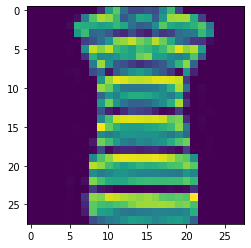

In [273]:
plt.imshow(img)

In [274]:
img.shape

torch.Size([28, 28])

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


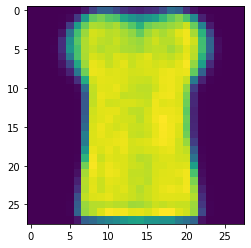

In [275]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [276]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][0]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


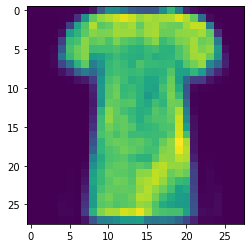

In [277]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [278]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][1]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


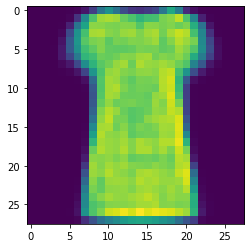

In [279]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [280]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][2]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


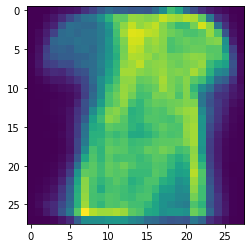

In [281]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [282]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][3]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


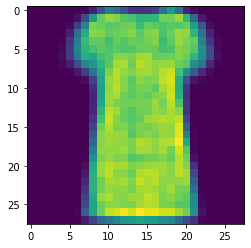

In [283]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [284]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][4]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


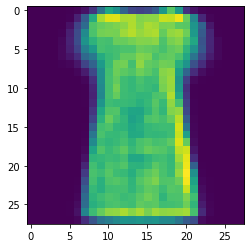

In [285]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [286]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][5]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


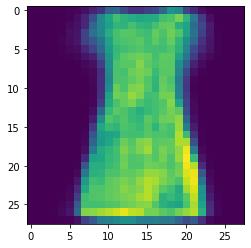

In [287]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [288]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][6]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


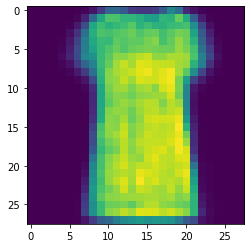

In [289]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [290]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][7]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


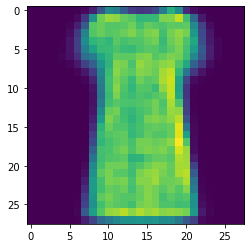

In [291]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [292]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][8]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


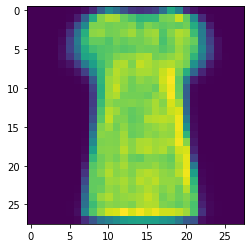

In [293]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 


In [294]:
a=torch.zeros(1,10)
a
b=torch.zeros(1,10)
b[0][9]=1
c=a+b

torch.Size([1, 784])
torch.Size([1, 10])
torch.Size([1, 10])
<class 'torch.Tensor'>
torch.Size([1, 784])


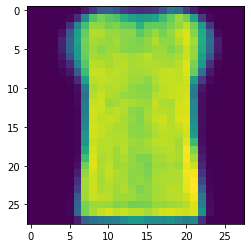

In [295]:
img=img.reshape(1,1,28,28)
img=img.view(1,28*28)
print(img.shape)
img=img.to(device)
mu,sigma=vae.encoder(img)
print(mu.shape)
z=vae.sampling(mu,sigma)
print(z.shape)
c=c.to(device)
z=z+c

x_reconstructed=vae.decoder(z)

print(type(x_reconstructed))
print(x_reconstructed.shape)

x_reconstructed=x_reconstructed.view(28,28)
x_reconstructed=x_reconstructed.cpu()
x_reconstructed=x_reconstructed.detach().numpy()

plt.imshow(x_reconstructed)




 
